In [63]:
# Preprocessing & results----------------
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder, normalize
# nlp preprocessing
import spacy
# Models-------------------------
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
import sklearn.gaussian_process.kernels as kls
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
# for visualizing ---------------
import pydotplus
from sklearn import tree
from sklearn.externals.six import StringIO 
from IPython.display import Image, display
import seaborn as sns
# General purpose
import re
import pandas as pd
import pickle
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the data
# link to the data below - https://drive.google.com/open?id=1GAVoYBwtb4TK-XaCzgYvUePIvjf-acku
data_raw = pd.read_pickle('./features/data_features_csv-2017.pkl')
data_raw.head(2)

,id,original,number,cdate,tcdate,tmdate,ddate,content,forum,referent,...,details,title,authors,abstract,keywords,replyCount,label,ref_latest,ref_len,ref_years
HJWHIKqgl,HJWHIKqgl,None,494,None,1478297149874,1559850667018,None,{'pdf': '/pdf/65f8efe9272decec6c0cc4fa4a6a871a...,HJWHIKqgl,None,...,{'replyCount': 12},Generative Models and Model Criticism via Opti...,"[Dougal J. Sutherland, Hsiao-Yu Tung, Heiko St...",We propose a method to optimize the representa...,[Unsupervised Learning],12,Accept,2019,34,"[2008, 2016, 2011, 2015, 2015, 2008, 2014, 200..."
SyK00v5xx,SyK00v5xx,None,448,None,1478291152993,1544202244497,None,{'pdf': '/pdf/3cd3d0e6d510ec56313971e66701feb3...,SyK00v5xx,None,...,{'replyCount': 19},A Simple but Tough-to-Beat Baseline for Senten...,"[Sanjeev Arora, Yingyu Liang, Tengyu Ma]",\nThe success of neural network methods for co...,"[Natural language processing, Unsupervised Lea...",19,Accept,2016,49,"[2012, 2012, 2013, 2013, 2014, 2015, 2016, 200..."


# Preprocessing

#### Contains ML keywords:

In [3]:
def ml_keywords_present(abstract):
    # collected from sense2vec spacy
    ml_keywords = ["outperforms", "outperform", "novel", "machine learning", "deep learning", "neural nets", "neural networks", "rnns", "rnn", "cnn", "cnns", "attention", "lstm", "adversarial network"]
    for keyw in ml_keywords:
        if abstract.lower().find(keyw) > -1:
            return 1
    return 0

#### Contains state-of-the-art

In [4]:
def sota_present(abstract):
    if abstract.lower().find('state-of-the-art') > -1 or abstract.lower().find('state of the art') > -1:
            return 1
    return 0

#### Glove vec average:

In [5]:
embeddings_dict = {}

with open("/home/shruti/data/glove/glove.6B/glove.6B.50d.txt", 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [6]:
nlp = spacy.load("en_core_web_sm")

In [7]:
def get_glove_avg(abstract):
    glove_avg = 0
    count = 0
    
    doc = nlp(abstract)
    
    for tok in doc:
        if not tok.is_stop:
            clean_token = tok.text.lower().strip()
            if clean_token in embeddings_dict:
                count += 1
                glove_avg += embeddings_dict[clean_token]
    
    if count > 1:
        return np.mean(glove_avg/count)
    else:
        return np.mean(glove_avg)

#### Avg sentence length of abstract

In [8]:
def avg_abs_sent_length(abstract):
    avg_sent_length = 0
    
    doc = nlp(abstract)
    for s in doc.sents:
        avg_sent_length += len(s)
    
    num_sents = len(list(doc.sents))
    
    if num_sents > 0:
        return avg_sent_length/num_sents
    else:
        return avg_sent_length

#### Number of recent references (last 5 year)

In [9]:
def get_num_recent_refs(list_refs):
    count = 0
    for i in list_refs:
        if int(i) >= 2012:
            count += 1
    return count

#### Loading the new features dict

In [12]:
new_features_from_text = None
with open('./OCR_workspace/feature_dict/2017_features.pkl', "rb") as f:
    new_features_from_text = pickle.load(f)

#### Avg. ref mention length in chars

In [24]:
def get_avg_ref_mention_length(id):
    year = 2017
    pid = id
    #pid = "2017" + "_" + id
    if pid in new_features_from_text:
        return new_features_from_text[pid]["avg_ref_mention"]
    else:
        print("Missing avg ref mention for ", pid)
        return 0

#### Number of sections

In [25]:
def get_num_sections(id):
    year = 2017
    pid = id
    #pid = "2017" + "_" + id
    if pid in new_features_from_text:
        return new_features_from_text[pid]["num_sections"]
        #TODO: check similar to the below cases as it will ruin for next year data
    else:
        print("Missing section for ", pid)
        return 4

#### Contains appendix

In [43]:
def contains_appendix(id):
    year = 2017
    pid=id
    #pid = "2017" + "_" + id
    if pid in new_features_from_text:
        if "contains_appendix" in new_features_from_text[pid]:
            return new_features_from_text[pid]["contains_appendix"]
        else:
            print("Key contains_appendix not present: ", pid)
            return 0
    else:
        print("Missing pid for ", pid)
        return 0

#### Count of tables, equations, figures

In [44]:
def get_count_of_fig_table_eqn(id):
    year = 2017
    pid=id
    #pid = "2017" + "_" + id
    if pid in new_features_from_text:
        if "table_ref_count" in new_features_from_text[pid] and "eqn_ref_count" in new_features_from_text[pid] and "fig_ref_count" in new_features_from_text[pid]:
            total_count = new_features_from_text[pid]["table_ref_count"] + new_features_from_text[pid]["fig_ref_count"] + new_features_from_text[pid]["eqn_ref_count"]
            return total_count
        else:
            print("Keys  count_of_fig_table_eqn keys missing for ", pid)
            return 0
    else:
        print("Missing pid for ", pid)
        return 0

### Feature Matrix Creation

In [68]:
data = pd.DataFrame()
data_raw = data_raw[data_raw['label']!='Invite']
data['id'] = data_raw['id']#.value_counts()
data['n_authors'] = data_raw['authors'].apply(len)#.value_counts()
data['len_char_title'] = data_raw['title'].apply(len)
data['len_word_title'] = data_raw['title'].apply(lambda x: len(re.split(':|\s',x)))
data['len_char_abstract'] = data_raw['abstract'].apply(len)
data['len_word_abstract'] = data_raw['abstract'].apply(lambda x: len(re.split(':|\s',x)))
# data['replyCount'] = data_raw['replyCount']
data['n_keywords'] = data_raw['keywords'].apply(len)
data['ref_len'] = data_raw['ref_len']
data['ref_latest'] = data_raw['ref_latest']
data['label'] = data_raw['label']
data['contains_ml_keyword'] = data_raw['abstract'].apply(ml_keywords_present)
data['avg_sent_len'] = data_raw['abstract'].apply(avg_abs_sent_length)
data['abs_glove_avg'] = data_raw['abstract'].apply(get_glove_avg)
data['contains_sota'] = data_raw['abstract'].apply(sota_present)
#data.to_pickle('/content/drive/My Drive/Colab Notebooks/ML Project/data/data-2017-20.pkl')

In [70]:
data['num_recent_refs'] = data_raw['ref_years'].apply(get_num_recent_refs)
data['avg_ref_length'] = data_raw['id'].apply(get_avg_ref_mention_length)
data['num_sections'] = data_raw['id'].apply(get_num_sections)
data['contains_appendix'] = data_raw['id'].apply(contains_appendix)
data['fig_tab_eqn_count'] = data_raw['id'].apply(get_count_of_fig_table_eqn)

data.head(2)

Key contains_appendix not present:  r1Usiwcex
Keys  count_of_fig_table_eqn keys missing for  r1Usiwcex


,id,n_authors,len_char_title,len_word_title,len_char_abstract,len_word_abstract,replyCount,n_keywords,ref_len,ref_latest,label,contains_ml_keyword,avg_sent_len,abs_glove_avg,contains_sota,num_recent_refs,avg_ref_length,num_sections,contains_appendix,fig_tab_eqn_count
HJWHIKqgl,HJWHIKqgl,7,76,10,996,160,12,1,34,2019,Accept,1,36.400000,0.061303,0,21,216,6,1,18
SyK00v5xx,SyK00v5xx,3,59,8,1611,253,19,2,49,2016,Accept,1,22.692308,0.059600,0,35,28,12,1,16


In [48]:
data[data.isnull().any(axis=1)]

,id,n_authors,len_char_title,len_word_title,len_char_abstract,len_word_abstract,replyCount,n_keywords,ref_len,ref_latest,label,contains_ml_keyword,avg_sent_len,abs_glove_avg,contains_sota,num_recent_refs,avg_ref_length,num_sections,contains_appendix,fig_tab_eqn_count


In [49]:
# shuffle the data
data = data.sample(n=len(data), random_state=42)

In [57]:
# To plot the Decision Tree--------------------------------------------
def plot(clf):
  dot_data = StringIO()
  tree.export_graphviz(clf[0], 
  out_file=dot_data, 
  class_names=['Accept','Reject'], # the target names.
  feature_names=X.columns, # the feature names.
  filled=True, # Whether to fill in the boxes with colours.
  rounded=True, # Whether to round the corners of the boxes.
  special_characters=True)
  graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
  return Image(graph.create_png())

# All models

In [58]:
clf_dict = {'DecisionTree':DecisionTreeClassifier(max_depth=3),
            'RandomForest':RandomForestClassifier(max_depth=10),
            'LogisticR':LogisticRegression(max_iter=5000),
            'LogisticLassoR':LogisticRegression(max_iter=5000, penalty='l1',solver='liblinear'),
            'RidgeClf':RidgeClassifier(max_iter=5000),
            'SVC':SVC(kernel='rbf'),
            'GaussNB':GaussianNB(),
            'NeuralNet':MLPClassifier((50),activation='logistic'),
            'KNN':KNeighborsClassifier(n_neighbors=10),
            'GaussianProcessClf':GaussianProcessClassifier(kernel=kls.RBF())
            }

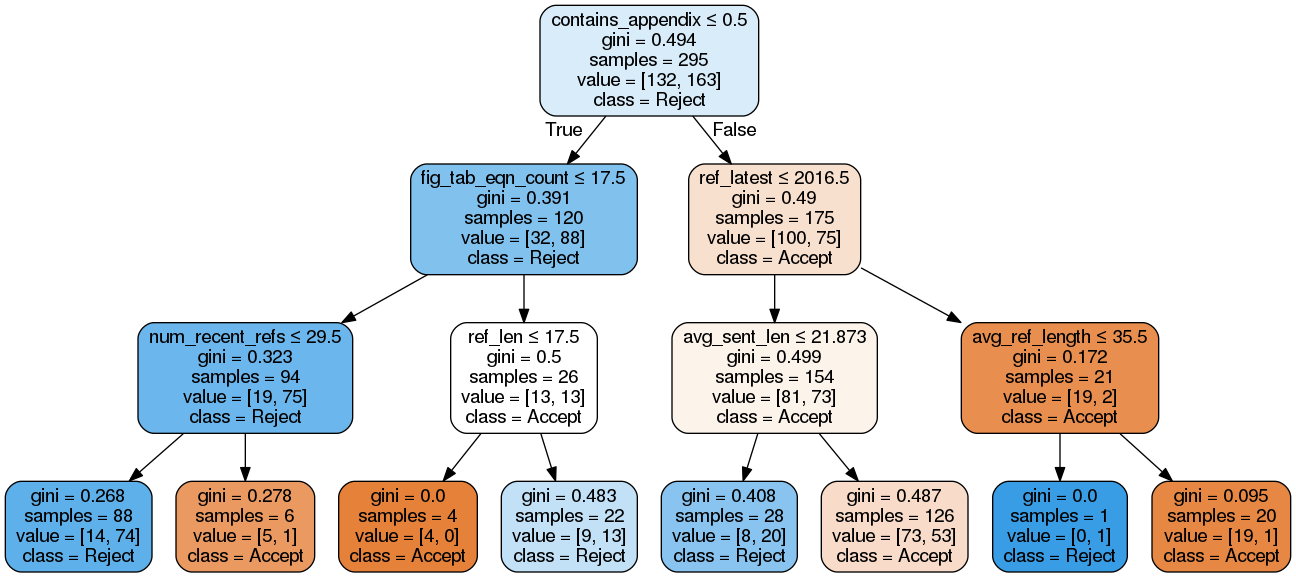

In [59]:
model_results = pd.DataFrame()
model_results['Accuracy'] = None
model_results['CVresults'] = None

for clf_name,clf in clf_dict.items():
#   X = data.drop(columns=['id','label'])
  X = data.drop(columns=['id','label'])
  y = data['label']
  results = cross_validate(clf, X, y, return_estimator=True)
  clf = results['estimator']
  results.pop('estimator')
  accuracy = np.mean(results['test_score'])
  model_results.loc[clf_name, ['Accuracy', 'CVresults']] = [accuracy, results]
  if clf_name == 'DecisionTree':
    display(plot(clf))

In [53]:
# Model results with all the new features
model_results

,Accuracy,CVresults
NeuralNet,0.577802,"{'score_time': [0.004859209060668945, 0.004551..."
GaussNB,0.623169,"{'score_time': [0.0038678646087646484, 0.00378..."
SVC,0.553043,"{'score_time': [0.008522987365722656, 0.002063..."
LogisticLassoR,0.661457,"{'score_time': [0.0009112358093261719, 0.00106..."
RandomForest,0.6568,"{'score_time': [0.0017852783203125, 0.00162696..."
DecisionTree,0.611739,"{'score_time': [0.0009336471557617188, 0.00092..."
LogisticR,0.663725,"{'score_time': [0.0009593963623046875, 0.00090..."
RidgeClf,0.665977,"{'score_time': [0.004842042922973633, 0.004171..."
KNN,0.571168,"{'score_time': [0.03751230239868164, 0.0140860..."
GaussianProcessClf,0.474168,"{'score_time': [0.009183168411254883, 0.009622..."


In [60]:
# Model results with all the new features and removing replyCount
model_results

,Accuracy,CVresults
NeuralNet,0.553089,"{'score_time': [0.004538059234619141, 0.004548..."
GaussNB,0.620794,"{'score_time': [0.0038335323333740234, 0.00436..."
SVC,0.553043,"{'score_time': [0.008400440216064453, 0.008330..."
LogisticLassoR,0.61629,"{'score_time': [0.0009140968322753906, 0.00095..."
RandomForest,0.573466,"{'score_time': [0.0018038749694824219, 0.00172..."
DecisionTree,0.595928,"{'score_time': [0.0009217262268066406, 0.00095..."
LogisticR,0.611755,"{'score_time': [0.0015411376953125, 0.00122761..."
RidgeClf,0.598241,"{'score_time': [0.0016722679138183594, 0.00138..."
KNN,0.523656,"{'score_time': [0.005907535552978516, 0.005666..."
GaussianProcessClf,0.516976,"{'score_time': [0.019641637802124023, 0.028387..."


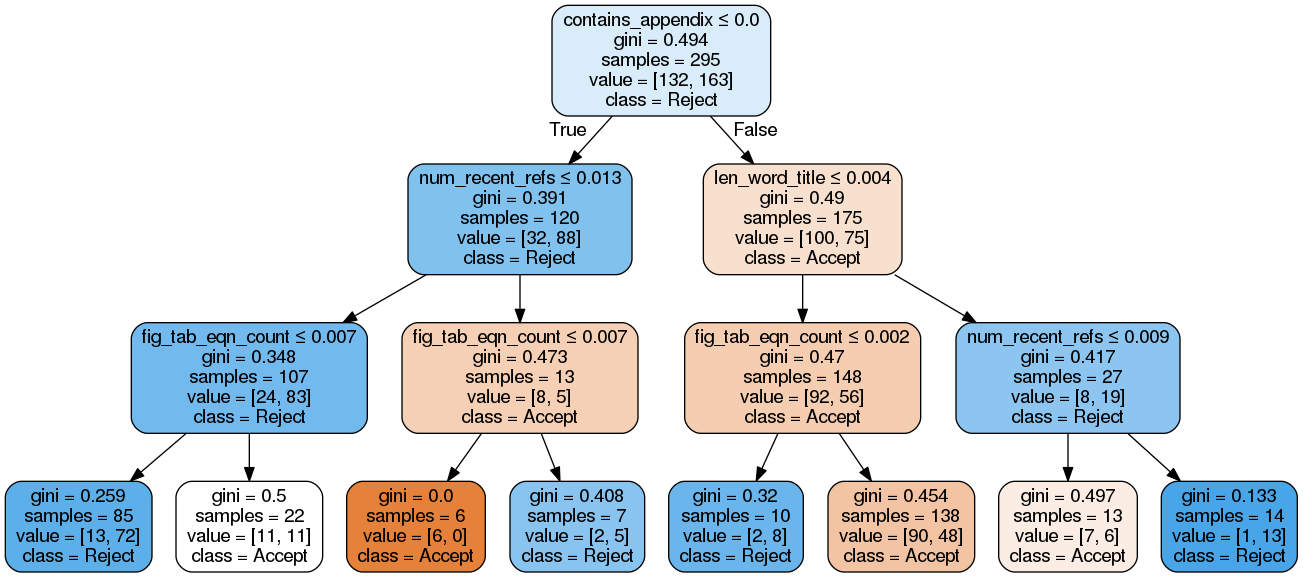

In [64]:
#Without replyCount and normalized
model_results = pd.DataFrame()
model_results['Accuracy'] = None
model_results['CVresults'] = None

for clf_name,clf in clf_dict.items():
#   X = data.drop(columns=['id','label'])
  X = data.drop(columns=['id','label'])
  y = data['label']
  X_normalized = normalize(X)
  results = cross_validate(clf, X_normalized, y, return_estimator=True)
  clf = results['estimator']
  results.pop('estimator')
  accuracy = np.mean(results['test_score'])
  model_results.loc[clf_name, ['Accuracy', 'CVresults']] = [accuracy, results]
  if clf_name == 'DecisionTree':
    display(plot(clf))

In [65]:
model_results

,Accuracy,CVresults
NeuralNet,0.553043,"{'score_time': [0.007280111312866211, 0.002499..."
GaussNB,0.641172,"{'score_time': [0.0020821094512939453, 0.00203..."
SVC,0.553043,"{'score_time': [0.006714820861816406, 0.006712..."
LogisticLassoR,0.553043,"{'score_time': [0.0004515647888183594, 0.00046..."
RandomForest,0.582475,"{'score_time': [0.0012333393096923828, 0.00120..."
DecisionTree,0.577864,"{'score_time': [0.0004684925079345703, 0.00046..."
LogisticR,0.553043,"{'score_time': [0.0006327629089355469, 0.00068..."
RidgeClf,0.553043,"{'score_time': [0.0009386539459228516, 0.00071..."
KNN,0.530459,"{'score_time': [0.006840944290161133, 0.005268..."
GaussianProcessClf,0.553043,"{'score_time': [0.012944698333740234, 0.009742..."


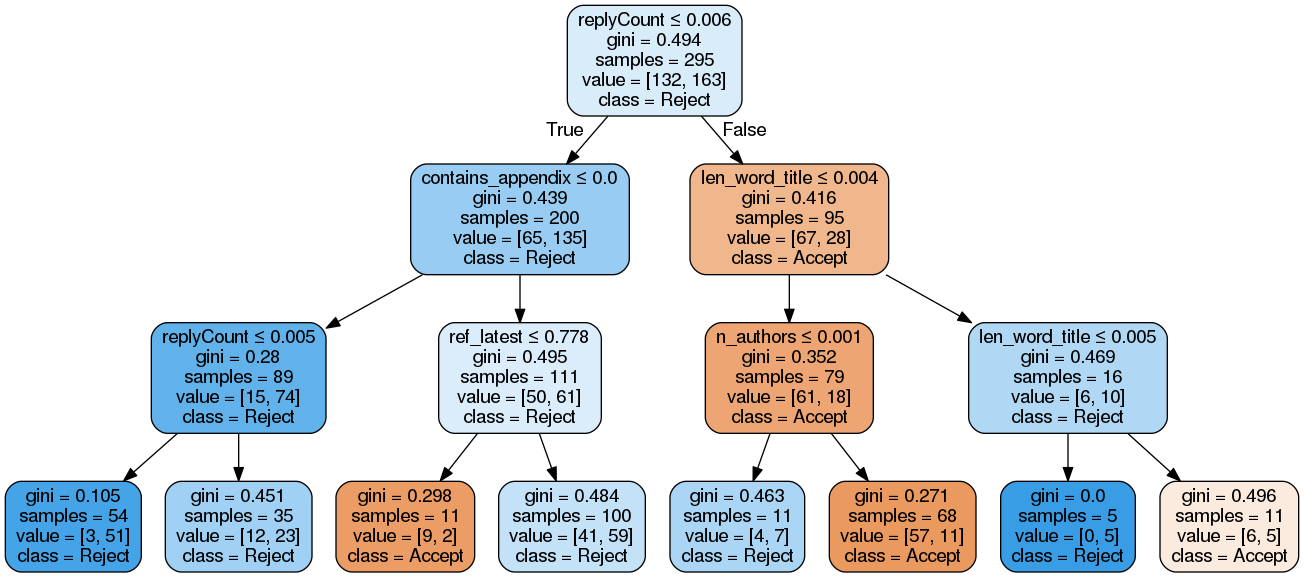

In [71]:
#With replyCount and normalized
model_results = pd.DataFrame()
model_results['Accuracy'] = None
model_results['CVresults'] = None

for clf_name,clf in clf_dict.items():
#   X = data.drop(columns=['id','label'])
  X = data.drop(columns=['id','label'])
  y = data['label']
  X_normalized = normalize(X)
  results = cross_validate(clf, X_normalized, y, return_estimator=True)
  clf = results['estimator']
  results.pop('estimator')
  accuracy = np.mean(results['test_score'])
  model_results.loc[clf_name, ['Accuracy', 'CVresults']] = [accuracy, results]
  if clf_name == 'DecisionTree':
    display(plot(clf))

In [72]:
model_results

,Accuracy,CVresults
NeuralNet,0.553043,"{'score_time': [0.0017015933990478516, 0.00172..."
GaussNB,0.650181,"{'score_time': [0.0013899803161621094, 0.00137..."
SVC,0.553043,"{'score_time': [0.004683494567871094, 0.004675..."
LogisticLassoR,0.553043,"{'score_time': [0.0011954307556152344, 0.00118..."
RandomForest,0.589217,"{'score_time': [0.001378774642944336, 0.001263..."
DecisionTree,0.571061,"{'score_time': [0.0005383491516113281, 0.00051..."
LogisticR,0.553043,"{'score_time': [0.0005624294281005859, 0.00049..."
RidgeClf,0.553043,"{'score_time': [0.0005311965942382812, 0.00052..."
KNN,0.528191,"{'score_time': [0.005429983139038086, 0.004475..."
GaussianProcessClf,0.553043,"{'score_time': [0.006630897521972656, 0.006561..."


### To update in md format

In [0]:
# Copy the results into .md file to visualize the table in .md
model_results.drop(columns=['CVresults']).to_html().replace('\n','')

'<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th></th>      <th>Accuracy</th>    </tr>  </thead>  <tbody>    <tr>      <th>DecisionTree</th>      <td>0.588994</td>    </tr>    <tr>      <th>RandomForest</th>      <td>0.650026</td>    </tr>    <tr>      <th>LogisticR</th>      <td>0.661364</td>    </tr>    <tr>      <th>LogisticLassoR</th>      <td>0.665858</td>    </tr>    <tr>      <th>RidgeClf</th>      <td>0.672549</td>    </tr>    <tr>      <th>SVC</th>      <td>0.553064</td>    </tr>    <tr>      <th>GaussNB</th>      <td>0.641088</td>    </tr>    <tr>      <th>NeuralNet</th>      <td>0.589147</td>    </tr>    <tr>      <th>KNN</th>      <td>0.555414</td>    </tr>    <tr>      <th>GaussianProcessClf</th>      <td>0.562028</td>    </tr>  </tbody></table>'